<a href="https://colab.research.google.com/github/chaitanya-kh/regression_models/blob/master/Boston_housing_predictions_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston housing dataset

This is continuation of other notebook which is Boston_housing_predictions.ipynb

This covers the low level tensorflow implementation of the DNN model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

In [2]:
print(tf.__version__)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(test_split=0.2, seed=4)

print ('x_train.shape: ', x_train.shape)
print ('y_train.shape: ', y_train.shape)
print ('x_test.shape: ', x_test.shape)
print ('y_test.shape: ', y_test.shape)

1.14.0
x_train.shape:  (404, 13)
y_train.shape:  (404,)
x_test.shape:  (102, 13)
y_test.shape:  (102,)


In [0]:
#Feature scaling is necessary for most of the ML models

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train_s = sc_x.fit_transform(x_train)
y_train_s = sc_y.fit_transform(y_train.reshape(-1,1))
x_test_s = sc_x.transform(x_test)
y_test_s = sc_y.transform(y_test.reshape(-1,1))

In [0]:
#Function to plot 
def plot_curves(yp, yt):
  plt.figure(figsize=(15,5))
  plt.plot(yp, color='red', marker='o')
  plt.plot(yt, color='blue', marker='x')
  plt.title('Test set: pred vs true')
  plt.ylabel('op')
  plt.xlabel('n')
  plt.legend(['predicted', 'true'], loc='upper right')
  

#Function to caclulate regressor errors
def calc_regressor_errors(yp, yt):
  mse = np.sum((yp - yt)*(yp - yt))/yp.shape[0]
  mae = np.sum(np.abs((yp - yt)))/yp.shape[0]
  print ("MSE is: ", mse, "\nMAE is: ", mae)
      
  error_percent = (yp-yt)/yt*100
  print ("mean error percent: ", np.mean(np.abs(error_percent)))
  print ("SD of error percent: ", np.std(error_percent))
  print ("max error percent: ", np.max(error_percent))
  print ("min error percent: ", np.min(error_percent))
  plt.title('error percentage distribution')
  plt.ylabel('error percent')
  sns.kdeplot(error_percent)
  
  acc_5p = len(np.where((error_percent>=-5) & (error_percent<=5))[0])/len(yp)
  acc_10p = len(np.where((error_percent>=-10) & (error_percent<=10))[0])/len(yp)
  acc_15p = len(np.where((error_percent>=-15) & (error_percent<=15))[0])/len(yp)
  acc_20p = len(np.where((error_percent>=-20) & (error_percent<=20))[0])/len(yp)
  
  print('+/- 5% accuracy: ',acc_5p*100,'%')
  print('+/- 10% accuracy: ',acc_10p*100,'%')
  print('+/- 15% accuracy: ',acc_15p*100,'%')
  print('+/- 20% accuracy: ',acc_20p*100,'%')
  
  plot_curves(yp, yt)

### Deeplearning regressor with tensorflow

This Model to be implemented using tf.nn operations rather than using tf.layers or keras.
This model will be similar to above deeplearning regressor model with an input layer, 3 deep layers

Plan of attack:

1.   layer1 with 78 units
3.   layer2 with 39 units
5.   layer3 with 13 units
7.   output layer

In [0]:
tf.reset_default_graph()

#Placeholders for x and y
x_inp = tf.placeholder(shape=(None,x_test.shape[1]), dtype=tf.float32, name='x_inp')
y_inp = tf.placeholder(shape=(None,1), dtype=tf.float32, name='y_inp')
y_pred_ph = tf.placeholder(shape=(None,1), dtype=tf.float32, name='y_pred_ph')

is_training = tf.placeholder(dtype=tf.bool, name='is_training')

#Kernel weights initializer
weights = tf.initializers.he_normal(seed=4)
zeros = tf.initializers.zeros()
ones = tf.initializers.ones()

#Batch info
batch_size = 101
batches = 4

In [0]:
#Full layer with no bias
def full_layer_simple(inp_layer, units, name, is_training):
  #Weights shape: inp_layer.cols * units
  w_shape = (int(inp_layer.get_shape()[1]), units)
  with tf.variable_scope(name):
    W = tf.get_variable(initializer=weights(shape=w_shape, dtype=tf.float32), dtype=tf.float32, name='W')
    
    print(name, ' inp dim: ', inp_layer.get_shape())
    print(name, ' weight dim: ', w_shape)
    print(name, ' op dim: ', (inp_layer.get_shape()[0], units))
    print()
    
    return tf.nn.relu(tf.matmul(inp_layer, W))

  
  
  
#Full layer with bias
def full_layer_bias(inp_layer, units, name, is_training):
  w_shape = (int(inp_layer.get_shape()[1]), units)
  b_shape = (units,)
  with tf.variable_scope(name):
    W = tf.get_variable(initializer=weights(shape=w_shape, dtype=tf.float32), dtype=tf.float32, name='W')
    b = tf.get_variable(initializer=zeros(shape=b_shape, dtype=tf.float32), dtype=tf.float32, name='b')
    
    print(name, ' inp dim: ', inp_layer.get_shape())
    print(name, ' weight dim: ', w_shape)
    print(name, ' bias dim: ', b_shape)
    print(name, ' op dim: ', (inp_layer.get_shape()[0], units))
    print()
    
  return tf.nn.relu(tf.matmul(inp_layer, W) + b)




#Full layer with bias and batch normalization
one = tf.constant(True, dtype=tf.bool)

#This is for debug logs
tns = {'o': dict(), 's': dict(), 'm': dict(), 'v': dict(), 'c': dict(), 'bm': dict(), 'bv': dict()}

#Function to calculate batch normalization for input data. Need to compute rolling mean and
#variance in case of training set based on batch mean and batch variance.
#Use calculated rolling mean and variance for test set
def bn(inp_layer, name, is_training):
  sh = (inp_layer.get_shape()[1],)
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    off = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='off')
    scale = tf.get_variable(initializer=ones(shape=sh, dtype=tf.float32), dtype=tf.float32, name='scale')
    set_mean = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='set_mean', trainable=False)
    set_variance = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='set_variance', trainable=False)
    b_mean = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='b_mean', trainable=False)
    b_variance = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='b_variance', trainable=False)
    counter = tf.get_variable(initializer=zeros(shape=sh, dtype=tf.float32), dtype=tf.float32, name='counter', trainable=False)
    
    def bn_train():
      batch_mean, batch_variance = tf.nn.moments(inp_layer, [0], name=name)
      with tf.control_dependencies([batch_mean, batch_variance]):
        op_mean = tf.assign(set_mean, tf.divide(tf.add(tf.multiply(set_mean,counter),batch_mean),tf.add(counter,1)))
 
        ####The below formula is wrong for computing rolling variance. need to correct it
        op_variance = tf.assign(set_variance, tf.divide(tf.add(tf.multiply(set_variance,counter),batch_variance),tf.add(counter,1)))
    
        op_b_mean = tf.assign(b_mean, batch_mean)
        op_b_variance = tf.assign(b_variance, batch_variance)
        with tf.control_dependencies([op_mean, op_variance, op_b_mean, op_b_variance]):
          op_counter = tf.assign(counter, counter+1)
          with tf.control_dependencies([op_counter]):
            return tf.nn.batch_normalization(inp_layer, batch_mean, batch_variance, off, scale, 0.001, name)
      
    def bn_test():
      return tf.nn.batch_normalization(inp_layer, set_mean, set_variance, off, scale, 0.001, name)
    
    #Updating the debug structure. can do session.run() to log any of the below values
    tns['o'][name] = off
    tns['s'][name] = scale
    tns['m'][name] = set_mean
    tns['v'][name] = set_variance
    tns['c'][name] = counter
    tns['bm'][name] = b_mean
    tns['bv'][name] = b_variance
    
    return tf.cond(tf.equal(is_training, one), bn_train, bn_test)
    
    
    

def full_layer_bn(inp_layer, units, name, is_training):
  w_shape = (int(inp_layer.get_shape()[1]), units)
  b_shape = (units,)
  with tf.variable_scope(name):
    W = tf.get_variable(initializer=weights(shape=w_shape, dtype=tf.float32), dtype=tf.float32, name='W')
    b = tf.get_variable(initializer=zeros(shape=b_shape, dtype=tf.float32), dtype=tf.float32, name='b')
  
  inp = bn(tf.matmul(inp_layer, W) + b, name, is_training)
  
  print(name, ' inp dim: ', inp_layer.get_shape())
  print(name, ' weight dim: ', w_shape)
  print(name, ' bias dim: ', b_shape)
  print(name, ' op dim: ', (inp.get_shape()[0], units))
  print()  
           
  return tf.nn.relu(inp)
  
 

In [7]:
#Build the simple network

#fls = bn(x_inp, 'fls', is_training)
fls1 = full_layer_bn(x_inp, 78, 'fls1', is_training)
fls2 = full_layer_bn(fls1, 39, 'fls2', is_training)
fls3 = full_layer_bn(fls2, 13, 'fls3', is_training)
y_pred = full_layer_bias(fls3, 1, 'fls4', is_training)

#print (tns)


#fls1 = full_layer_bias(x_inp, 78, 'fls1', is_training)
#fls2 = full_layer_bias(fls1, 39, 'fls2', is_training)
#fls3 = full_layer_bias(fls2, 13, 'fls3', is_training)
#y_pred = full_layer_bias(fls3, 1, 'fls4', is_training)

fls1  inp dim:  (?, 13)
fls1  weight dim:  (13, 78)
fls1  bias dim:  (78,)
fls1  op dim:  (Dimension(None), 78)

fls2  inp dim:  (?, 78)
fls2  weight dim:  (78, 39)
fls2  bias dim:  (39,)
fls2  op dim:  (Dimension(None), 39)

fls3  inp dim:  (?, 39)
fls3  weight dim:  (39, 13)
fls3  bias dim:  (13,)
fls3  op dim:  (Dimension(None), 13)

fls4  inp dim:  (?, 13)
fls4  weight dim:  (13, 1)
fls4  bias dim:  (1,)
fls4  op dim:  (Dimension(None), 1)



In [8]:
#Cost function and optimizer
cost = tf.reduce_mean(tf.losses.absolute_difference(y_inp, y_pred))
optimizer = tf.train.AdamOptimizer(0.001)
op = optimizer.minimize(cost)

#Metrics
tf_mae, tf_mae_op = tf.metrics.mean_absolute_error(y_inp, y_pred_ph, name='metrics')
tf_mse, tf_mse_op = tf.metrics.mean_squared_error(y_inp, y_pred_ph, name='metrics')

W0709 06:27:07.244069 140118138521472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
#Training the neural network
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
met = tf.get_collection('metrics')

for m in met:
  init_l.remove(m)

data_train = x_train_s
data_test = x_test_s


with tf.Session() as sess:
  sess.run([init_g])
  
  #print(sess.run([tns['m']['fls']]))
  for epoch in range(0,200):
    sess.run([init_l])
    #print ('epoch', epoch)
    #Train the network and update weights
    for ii in range(0, batches):
      s = ii*batch_size
      e = s+batch_size
      sess.run(op, feed_dict={is_training: True, 
                              x_inp: data_train[[iii for iii in range(s, e)],:], 
                              y_inp: y_train[s:e].reshape(-1,1)})
    
      #print(sess.run([tns['bv']['fls']]))
      #print(sess.run([tns['c']['fls']]))
      #print('***')
    #print(sess.run([tns['v']['fls']]))
    
    #Compute the loss and predicted values for training set
    loss_epoch, pred = sess.run((cost, y_pred), feed_dict={is_training: False,
                                          x_inp: data_train,
                                          y_inp: y_train.reshape(-1,1)})
    
    
    #print(sess.run([tns['c']['fls']]))
    #Compute the metrics for training set
    sess.run(met)
    sess.run([tf_mae_op, tf_mse_op], feed_dict={y_inp: y_train.reshape(-1,1),
                                                y_pred_ph: pred})
    
    loss_mae_epoch, loss_mse_epoch = sess.run([tf_mae, tf_mse])
    
    print ('Training: ', epoch+1, ' ', loss_epoch, ' ', loss_mae_epoch, ' ', loss_mse_epoch)
    
    #Compute the loss and predicted values for test set
    loss_epoch, pred = sess.run((cost, y_pred), feed_dict={is_training: False,
                                          x_inp: data_test,
                                          y_inp: y_test.reshape(-1,1)})
    #Compute the metrics for test set
    sess.run(met)
    sess.run([tf_mae_op, tf_mse_op], feed_dict={y_inp: y_test.reshape(-1,1),
                                                y_pred_ph: pred})
    
    loss_mae_epoch, loss_mse_epoch = sess.run([tf_mae, tf_mse])
    #print (pred[0:3])
    print ('Test    : ', epoch+1, ' ', loss_epoch, ' ', loss_mae_epoch, ' ', loss_mse_epoch)
    
    print()
  
  


Training:  1   22.043604   22.043604   576.89545
Test    :  1   22.128916   22.060802   575.2571

Training:  2   21.963451   21.963451   574.5925
Test    :  2   22.041426   21.97917   572.92865

Training:  3   21.900402   21.900402   572.83386
Test    :  3   21.978226   21.91609   571.14594

Training:  4   21.847275   21.847275   571.27423
Test    :  4   21.926586   21.863262   569.56805

Training:  5   21.796326   21.796326   569.69727
Test    :  5   21.877523   21.812693   567.96716

Training:  6   21.743456   21.743456   568.0351
Test    :  6   21.828028   21.760506   566.30237

Training:  7   21.689117   21.689117   566.2987
Test    :  7   21.777988   21.707031   564.58496

Training:  8   21.633509   21.633509   564.5039
Test    :  8   21.726885   21.652332   562.8148

Training:  9   21.578493   21.578493   562.7347
Test    :  9   21.675594   21.598066   561.0642

Training:  10   21.524769   21.524769   561.0239
Test    :  10   21.624897   21.544952   559.3674

Training:  11   21.4

In [10]:
pred[0:10].reshape(-1)

array([36.852356, 21.87441 , 13.27925 , 31.292768, 17.25331 , 15.864527,
       39.351788, 30.309013, 19.327602, 21.565426], dtype=float32)

In [11]:
y_test[0:10]

array([27.1, 14.5, 10.4, 21.4, 14.1, 10.2, 24.3, 18.6, 18.9, 10.9])

MSE is:  99.99345943083729 
MAE is:  9.000602056465896
mean error percent:  43.92815491165684
SD of error percent:  26.763974160141686
max error percent:  122.74088859558105
min error percent:  -38.89778518676758
+/- 5% accuracy:  4.901960784313726 %
+/- 10% accuracy:  6.862745098039216 %
+/- 15% accuracy:  10.784313725490197 %
+/- 20% accuracy:  12.745098039215685 %


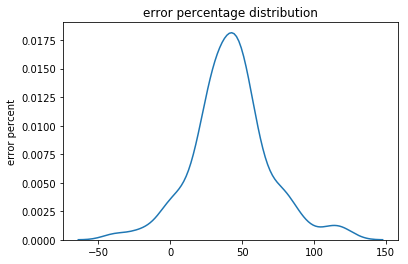

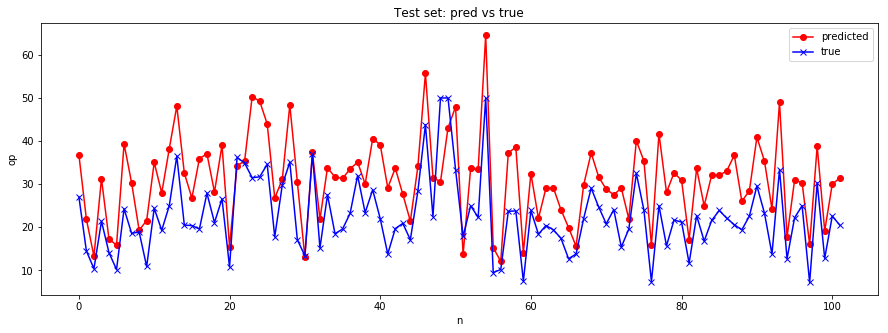

In [12]:
calc_regressor_errors(pred.reshape(-1), y_test)

This looks quite bad! Need to fix this by correcting formula for rolling variance

Surprising to see decent convergence even with wrong rolling variance